
# Compartments

In this notebook, we use files generated by the workflow `master_workflow` that, in short does:

1) Download the data from the source
2) Index the reference genome with `bwa index` and `samtools faidx`
3) Align the reads to the reference genome with `bwa mem`
4) Pair and sort the reads to `.pairs` files with `pairtools parse | pairtools sort`
5) Deduplicate the pairs with `pairtools dedup`
6) Convert the .pairs to cooler files with `cooler cload pairs`

In [18]:
#| echo: false

import pandas as pd

df = pd.read_csv('../data/SraRunTable.txt')[['source_name','Run', 'BioSample', 'Bases','Bytes']].sort_values(['source_name', 'Run'])
df['GB'] = df['Bytes'].apply(lambda x: f"{x / (1024 ** 3):.2f}")
df['Reads'] = df['Bases']/300
df = df[['source_name', 'BioSample', 'Run', 'GB', 'Bases', 'Reads']]

# Use the style method to format the columns for display
df.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})

# Hard code the formatting
# df[['Bases', 'Bytes', 'Reads']] = df[['Bases', 'Bytes', 'Reads']].map(lambda x: f"{int(x):,}")
#df


,source_name,BioSample,Run,GB,Bases,Reads
16,fibroblast,SAMN08375237,SRR6502335,29.77,"73,201,141,800","244,003,806"
17,fibroblast,SAMN08375237,SRR6502336,22.76,"65,119,970,100","217,066,567"
18,fibroblast,SAMN08375236,SRR6502337,21.43,"52,769,196,300","175,897,321"
19,fibroblast,SAMN08375236,SRR6502338,21.42,"52,378,949,100","174,596,497"
20,fibroblast,SAMN08375236,SRR6502339,10.21,"28,885,941,600","96,286,472"
9,fibroblast,SAMN08375237,SRR7349189,52.73,"139,604,854,200","465,349,514"
10,fibroblast,SAMN08375236,SRR7349190,53.09,"142,008,353,400","473,361,178"
21,pachytene spermatocyte,SAMN08375234,SRR6502342,60.26,"150,370,993,500","501,236,645"
22,pachytene spermatocyte,SAMN08375234,SRR6502344,27.15,"65,697,684,300","218,992,281"
23,pachytene spermatocyte,SAMN08375234,SRR6502345,26.20,"63,490,538,700","211,635,129"


# Compartments

Here, we will use `cooltools` in combination with `cooler` to find the A/B compartments in the chromatin of rep1 and rep2

## Do it with 500kb resolution

In [19]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [20]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools

In [23]:
cool_file = "../steps/bwa/PE/cool/fibroblast/fib_rep1.mcool"

clr = cooler.Cooler(f"{cool_file}::resolutions/500000")

In [24]:
import bioframe

bins = clr.bins()[:]
rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not os.path.exists('rheMac10_gc_cov_500kb.tsv'):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv('rheMac10_gc_cov_500kb.tsv', index=False,sep='\t')
    display(gc_cov)
else: 
    print("Already exists, just read from file:")
    gc_cov = pd.read_csv("rheMac10_gc_cov_500kb.tsv", sep='\t')
    display(gc_cov)

Calculate the fraction of GC basepairs for each bin


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/bioframe/extras.py:312: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("chrom", sort=False)[["start", "end"]].apply(_each)


,chrom,start,end,GC
0,chr1,0,500000,0.424508
1,chr1,500000,1000000,0.378836
2,chr1,1000000,1500000,0.388272
3,chr1,1500000,2000000,0.445226
4,chr1,2000000,2500000,0.439485
...,...,...,...,...
5715,chrY,9500000,10000000,0.399518
5716,chrY,10000000,10500000,0.396028
5717,chrY,10500000,11000000,0.395280
5718,chrY,11000000,11500000,0.382006


In [25]:
# Apparently, we have som NaN values, I don't know why (and only 1 on the X)
gc_cov[gc_cov['GC'].isna()].groupby('chrom').size()

/tmp/ipykernel_3629140/3571768165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gc_cov[gc_cov['GC'].isna()].groupby('chrom').size()


chrom
chr1     1
chr2     1
chr5     1
chr3     1
chr6     1
chr4     1
chr7     1
chrX     0
chr8     1
chr9     1
chr11    1
chr12    1
chr14    1
chr15    1
chr13    1
chr10    1
chr17    1
chr16    1
chr20    1
chr18    1
chr19    1
chrY     1
dtype: int64

In [26]:
view_df = pd.DataFrame(
    {
    'chrom': clr.chromnames,
    'start': 0,
    'end': clr.chromsizes.values,
    'name': clr.chromnames
    }
                      )
display(view_df)

,chrom,start,end,name
0,chr1,0,223616942,chr1
1,chr2,0,196197964,chr2
2,chr5,0,187317192,chr5
3,chr3,0,185288947,chr3
4,chr6,0,179085566,chr6
5,chr4,0,169963040,chr4
6,chr7,0,169868564,chr7
7,chrX,0,153388924,chrX
8,chr8,0,145679320,chr8
9,chr9,0,134124166,chr9


In [27]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
len(eigenvector_track)

/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):


5720

In [28]:
# full track
eigenvector_track

,chrom,start,end,E1
0,chr1,0,500000,-0.818737
1,chr1,500000,1000000,-1.052494
2,chr1,1000000,1500000,-0.946036
3,chr1,1500000,2000000,-0.550397
4,chr1,2000000,2500000,0.108430
...,...,...,...,...
5715,chrY,9500000,10000000,-0.523549
5716,chrY,10000000,10500000,-0.554934
5717,chrY,10500000,11000000,-1.022690
5718,chrY,11000000,11500000,-0.491319


In [29]:
# subset the chrX   
eigenvector_track_chrX = eigenvector_track.loc[eigenvector_track['chrom'] == 'chrX']
nbins = len(eigenvector_track_chrX)
eigenvector_track_chrX
e1X_values = eigenvector_track_chrX['E1'].values

In [34]:
%%capture chrX_matrix_e1_500kb

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = clr.bins()[:]['weight'].values
#ax1.plot([0,nbins],[0,0],'k',lw=0.25)

#ax1.plot(e1X_values, label='E1')

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1]['E1']>0).astype(int)))[0]:
    # Horisontal lines where E1 intersects 0
    #ax.plot([0,nbins],[i,i],'k',lw=0.5)

    # Vertical lines where E1 intersects 0
    ax.plot([i,i],[0,nbins],'k',lw=0.3)

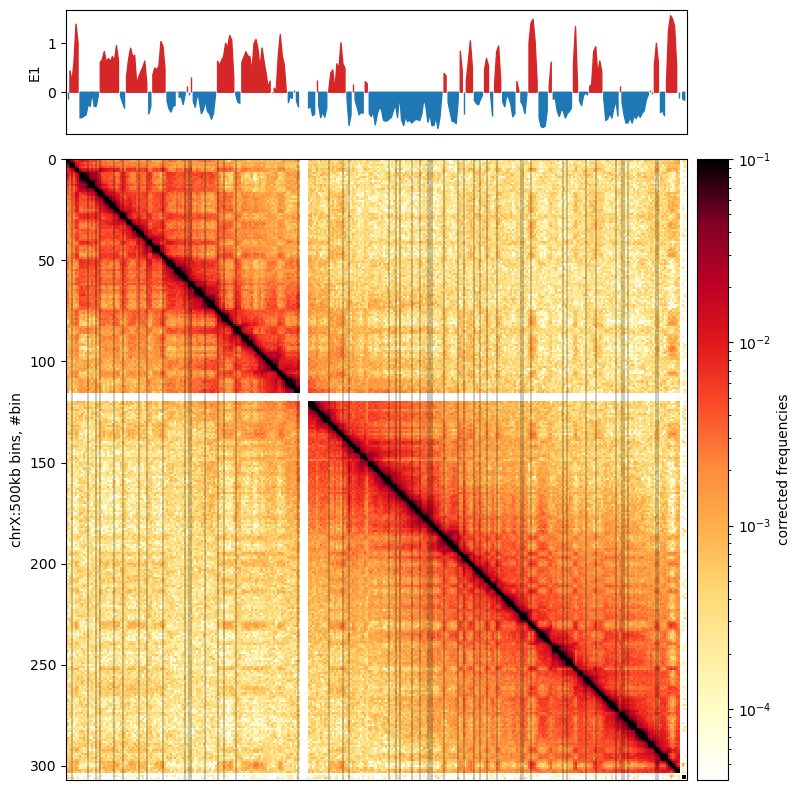

In [35]:
#| label: chrX-matrix-e1-500kb
#| fig-cap: "chrX interaction matrix with E1 eigenvector values. 500kb resolution"

chrX_matrix_e1_500kb()

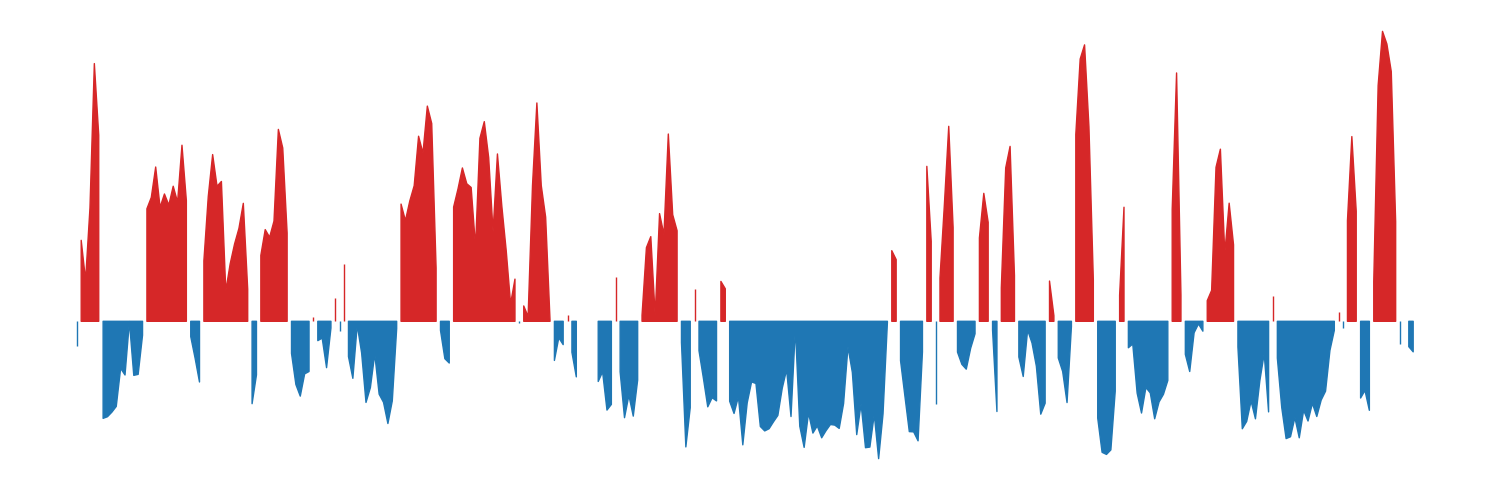

In [38]:
#| label: chrX-e1-500kb-plot
#| fig-cap: "500kb binned E1 eigenvector values for chrX. Freshly calculated from the cooler file."
#| fig-height: 1


import matplotlib.pyplot as plt

f, ax1 = plt.subplots(
    figsize=(15, 5),
)

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

#ax1.set_ylabel('E1')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.tight_layout()

# Save the plot as a high-resolution PNG file
plt.savefig('e1_plot.png', dpi=320, bbox_inches='tight')

plt.show()